<a href="https://colab.research.google.com/github/p0tat0-113/2024.DB/blob/main/03_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import sklearn

In [11]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [12]:
from sklearn.datasets import fetch_openml

# 사이킷런 1.2에서 추가된 parser 매개변수 기본값이 1.4 버전에서 'liac-arff'에서 'auto'로 바뀝니다.
# 'auto'일 경우 희소한 ARFF 포맷일 때는 'liac-arff', 그렇지 않을 때는 'pandas'가 됩니다.
# 이에 대한 경고를 피하려면 parser='auto'로 지정하세요.
mnist = fetch_openml('mnist_784', as_frame=False)

In [13]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [14]:
mnist.keys()  # 추가 코드 - 이 노트북에서는 data와 target만 사용합니다

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [15]:
X, y = mnist["data"], mnist["target"]

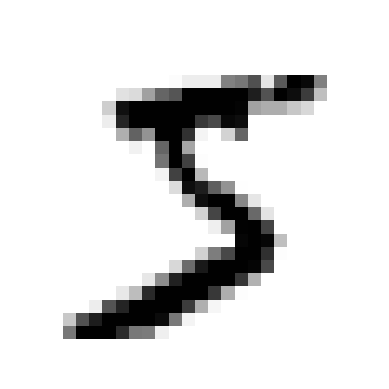

In [16]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary") #cmap="binary"로 설정해서 0을 흰색, 255를 검은색으로 나타내는 흑백 컬러맵을 사용한다.
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier 객체 생성 (기본적으로 이웃 수는 5개)
knn_clf = KNeighborsClassifier()

# 모델 훈련
knn_clf.fit(X_train, y_train)
knn_clf

KNeighborsClassifier()

In [20]:
knn_clf.predict([some_digit])

array(['5'], dtype=object)

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# 이상치를 제거하는 사용자 정의 변환기
class MNISTOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, min_pixel=0, max_pixel=255):
        self.min_pixel = min_pixel
        self.max_pixel = max_pixel

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        mask = np.all((X_ >= self.min_pixel) & (X_ <= self.max_pixel), axis=1)
        return X_[mask]

# 원래의 훈련 데이터와 레이블 복사
X_train_preprocessed = X_train.copy()
y_train_preprocessed = y_train.copy()

# 파이프라인 생성
pipeline = Pipeline([
    ('outlier_remover', MNISTOutlierRemover()),  # 이상치 제거
    ('scaler', StandardScaler()),  # 표준화
    ('minmax_scaler', MinMaxScaler()),  # 정규화
    ('knn', KNeighborsClassifier()),  # KNeighborsClassifier
])


# 훈련 데이터만 변환하여 KNeighborsClassifier 훈련
X_train_preprocessed = pipeline[:-1].fit_transform(X_train_preprocessed)
knn_clf_preprocessed = pipeline[-1].fit(X_train_preprocessed, y_train_preprocessed)
knn_clf_preprocessed

KNeighborsClassifier()

In [35]:
print(X_train_preprocessed[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [30]:
knn_clf_preprocessed.predict([some_digit])

array(['3'], dtype=object)

In [31]:
import pandas as pd
from sklearn.model_selection import cross_val_score

# knn_clf (전처리 없음)에 대한 3-폴드 교차 검증
scores_knn_clf = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

# knn_clf_preprocessed (전처리 포함)에 대한 3-폴드 교차 검증
# pipeline 객체를 직접 사용하여 교차 검증 수행
scores_knn_clf_preprocessed = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="accuracy")

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    "모델": ["knn_clf", "knn_clf_preprocessed"],
    "평균 정확도": [scores_knn_clf.mean(), scores_knn_clf_preprocessed.mean()],
    "표준 편차": [scores_knn_clf.std(), scores_knn_clf_preprocessed.std()],
})

# 표 출력
print(results)

                     모델    평균 정확도     표준 편차
0               knn_clf  0.967417  0.000225
1  knn_clf_preprocessed  0.967433  0.000236


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# pipeline을 사용하여 테스트 데이터 변환
X_test_transformed = pipeline[:-1].transform(X_test)

# 변환된 테스트 데이터에 대한 예측 확률 계산
y_scores = pipeline[-1].predict_proba(X_test_transformed)[:, 1]

# 정밀도, 재현율, 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# PR 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, linewidth=2, label="PR 곡선")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.title("PR 곡선 (knn_clf_preprocessed)")
plt.grid(True)
plt.legend()
plt.show()

# PR AUC 계산 및 출력
pr_auc = auc(recalls, precisions)
print(f"PR AUC: {pr_auc:.3f}")

ValueError: multiclass format is not supported

In [40]:
from sklearn.metrics import average_precision_score

# 평균 PR AUC 계산
y_scores = pipeline[-1].predict_proba(X_test_transformed)
average_precision = average_precision_score(y_test, y_scores, average="macro")

print(f"평균 PR AUC: {average_precision:.3f}")

평균 PR AUC: 0.984


In [42]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    'knn__n_neighbors': np.arange(1, 20),  # 이웃 수 (1~20)
    'knn__weights': ['uniform', 'distance'],  # 가중치 함수
    'knn__p': [1, 2],  # 거리 측정 방식 (1: Manhattan, 2: Euclidean)
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,  # 탐색 횟수 (10회)
    cv=3,  # 교차 검증 폴드 수 (3-폴드)
    scoring='accuracy',  # 평가 지표 (정확도)
    random_state=42,  # 랜덤 시드 설정
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=2, # 진행 상황 출력 (verbose=2)
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
print("최적 하이퍼파라미터:", random_search.best_params_)
print("최고 정확도:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 